# Tunnel+

***Goal***: To make an improved version of [Location+](https://library.fangraphs.com/pitching/stuff-location-and-pitching-primer/) that incorporates pitch tunneling. <br>
**Author**: Jensen Holm <br>
**Date**: 2024

In [1]:
%pip install git+https://github.com/Jensen-holm/statcast-era-pitches.git

  Cloning https://github.com/Jensen-holm/statcast-era-pitches.git to /private/var/folders/2_/kwjd2wv14q91l3mg7r83n04c0000gn/T/pip-req-build-ft0d3k0k
  Running command git clone --filter=blob:none --quiet https://github.com/Jensen-holm/statcast-era-pitches.git /private/var/folders/2_/kwjd2wv14q91l3mg7r83n04c0000gn/T/pip-req-build-ft0d3k0k
  Resolved https://github.com/Jensen-holm/statcast-era-pitches.git to commit 6ff4dcb3e47835ef8efbfd8fcddbe490d54fd7ae
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import statcast_pitches
import polars as pl
from plotnine import *
import plotly.express as px
import os

DATA_DIR = os.path.join("..", "data")

## Loading Data

Using all pitches thrown in the statcast-era (2015-present) as our data for this model. <br>
I will also be using `../data/run_values.csv` for calculating run values of each pitch, this data represents 2024 only.

**Data Dictionary**: [link](https://baseballsavant.mlb.com/csv-docs) <br>
**statcast_pitches package info**: [link](https://github.com/Jensen-holm/statcast-era-pitches)

In [3]:
# use statcast pitches to get all pitches thrown in since hawkeye began
pitches_lf: pl.LazyFrame = (statcast_pitches.load()
                            .filter(pl.col("game_date").dt.year() >= 2017))

latest_date = pitches_lf.select("game_date").max().collect().item().date()
earliest_date = pitches_lf.select("game_date").min().collect().item().date()
n_pitches = pitches_lf.select(pl.len()).collect().item()

print(f"N Pitches: {n_pitches}")
print(f"Date Range: {earliest_date} - {latest_date}")

N Pitches: 5573157
Date Range: 2017-04-02 - 2024-10-30


In [4]:
run_values_24 = pl.scan_csv(
    "https://raw.githubusercontent.com/Jensen-holm/tunnel-plus/refs/heads/main/data/run_values.csv"
).rename({"event": "events"}) # it is called 'events' in pitches_df

# Feature Engineering

adding the following features to `pitches_df`

| Feature Name | Description |
|------|-------------|
| **delta_run_exp** | run value associated with the pitch outcome from `run_values_24`|
| **x_0.120** | position in the x dimension of the pitch at decision time (~0.12s) |
| **y_0.120** | position in the y dimension of the pitch at decision time (~0.12s) |
| **z_0.120** | position in the z dimension of the pitch at decision time (~0.12s) |
| **x_0.167** | position in the x dimension of the pitch at commit time (~0.167s) |
| **y_0.167** | position in the y dimension of the pitch at commit time (~0.167s) |
| **z_0.167** | position in the z dimension of the pitch at commit time (~0.167s) |
| **velocity_diff** | difference in velocity between pitches in a two pitch sequence |
| **effective_velocity_diff** | difference in effective velocity between pitches in a two pitch sequence |
| **pfx_x_diff** | difference in horizontal movement between pitches in a two pitch sequence |
| **pfx_z_diff** | difference in vertical movement between pitches in a two pitch sequence |
| **3d_dist_0.167** | 3D euclidean distance between pitches in a two pitch sequence 0.167 seconds after release |
| **3d_dist_0.120** | 3D distance between pitches in a two pitch sequence at 0.120 seconds after release |
| **distance** | 2D euclidean distance between pitch locations when crossing the plate in a two pitch sequence |
| **seq_delta_run_exp** | sum of `delta_run_exp` in a two pitch sequence |
| **plate_x_diff** | difference in plate_x between pitches in a two pitch sequence |
| **plate_z_diff** | difference in plate_z between pitches in a two pitch sequence |

On top of adding these features, attributes from LHP should be mirrored as if they were thrown by a RHP for consistency

Joining the expected runs from run_values_24 to the pitches dataframe so that each pitch has an associated run value.

**New Features**

- `delta_run_exp`

In [5]:

description_replace_mapping = {
    "Ball": "ball",
    "In play, run(s)": "hit_into_play",
    "In play, out(s)": "hit_into_play",
    "In play, no out": "hit_into_play",
    "Called Strike": "called_strike",
    "Foul": "foul",
    "Swinging Strike": "swinging_strike",
    "Blocked Ball": "ball",
    "Swinging Strike (Blocked)": "swinging_strike",
    "Foul Tip": "swinging_strike",
    "Foul Bunt": "foul",
    "Hit By Pitch": "hit_by_pitch",
    "Pitchout": "ball",
    "Missed Bunt": "swinging_strike",
    "Bunt Foul Tip": "swinging_strike",
    "Foul Pitchout": "foul",
    "Ball In Dirt": "ball",
}

def add_pitch_run_value(lf: pl.LazyFrame) -> pl.LazyFrame:
    """Takes in a dataframe of pitches, and adds 2024 run value to each one"""
    pitch_runs_lf = lf.join(
        other=run_values_24,
        on=["events", "balls", "strikes"],
        how="left",
    )

    mapped_des_pitches = pitch_runs_lf.with_columns([
        pl.col("description")
        .replace_strict(description_replace_mapping, default=None)
        .alias("play_des"),
    ])

    pitches_run_value_lf = mapped_des_pitches.join(
        other=run_values_24,
        right_on=["events", "balls", "strikes"],
        left_on=["play_des", "balls", "strikes"],
        how="left",
        suffix="_des",
    ).with_columns([
        pl.when(pl.col("delta_run_exp").is_null())
        .then(pl.col("delta_run_exp_des"))
        .otherwise(pl.col("delta_run_exp"))
        .alias("delta_run_exp"),
    ])
    return pitches_run_value_lf

pitches_run_value_lf = pitches_lf.pipe(add_pitch_run_value)
pitches_run_value_lf.select(
    "pitch_type",
    "description",
    "balls",
    "strikes",
    "delta_run_exp",
).describe()

statistic,pitch_type,description,balls,strikes,delta_run_exp
str,str,str,f64,f64,f64
"""count""","""5477692""","""5573157""",5.573157e6,5.573157e6,5.383124e6
"""null_count""","""95465""","""0""",0.0,0.0,190033.0
"""mean""",null,null,0.875817,0.891433,0.000004
"""std""",null,null,0.96787,0.827898,0.243725
"""min""","""CH""","""ball""",0.0,0.0,-1.661
"""25%""",null,null,0.0,0.0,-0.067
"""50%""",null,null,1.0,1.0,-0.018
"""75%""",null,null,1.0,2.0,0.037
"""max""","""SV""","""swinging_strike_blocked""",4.0,3.0,3.702


In order to keep it simple, I am mirroring the movement and the horizontal release position of each pitch thrown from LHP, to as if it were thrown by RHP.

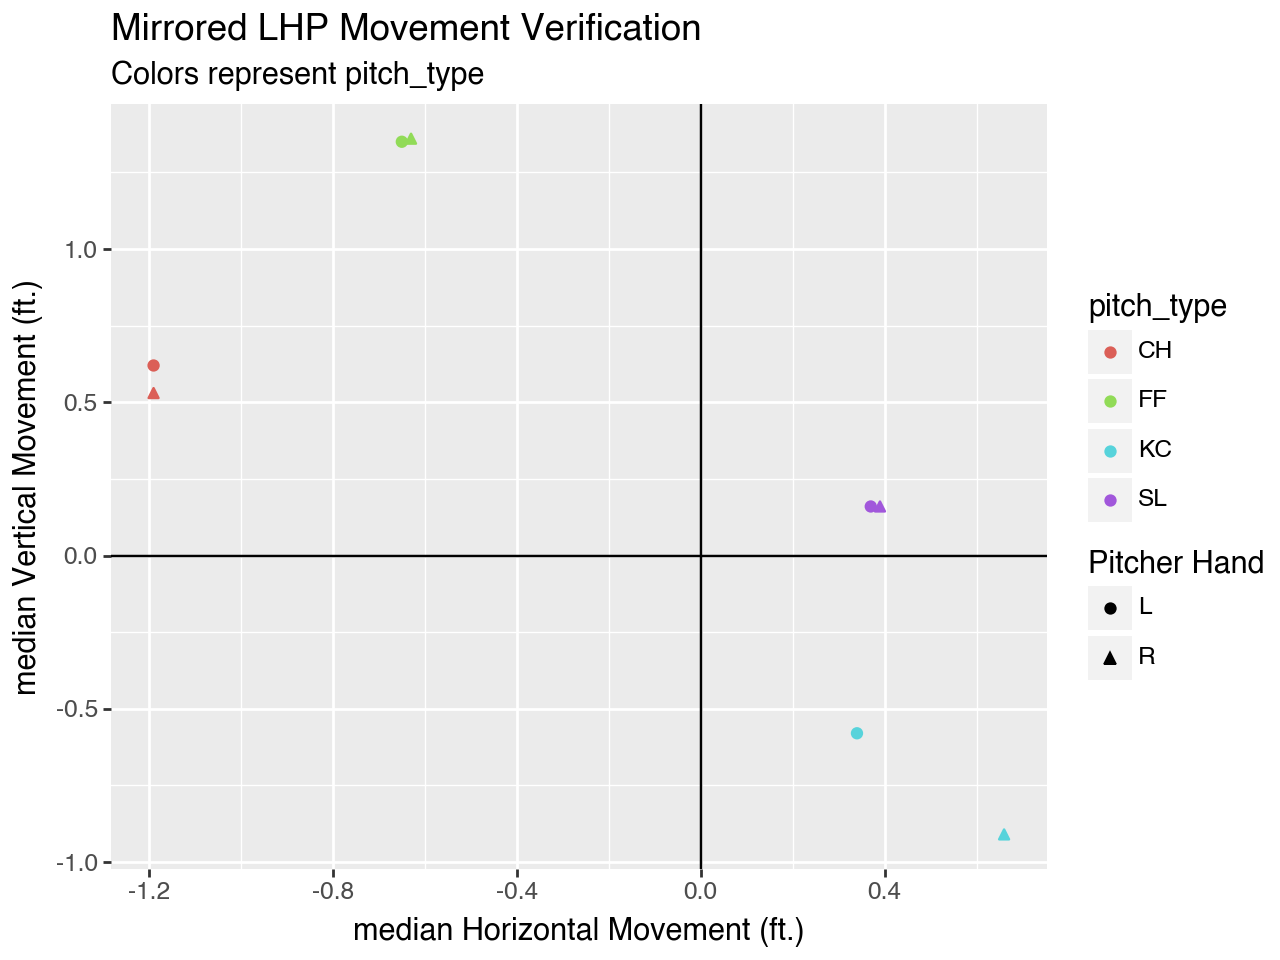

In [6]:
def mirror_lhp_to_rhp(lf: pl.LazyFrame) -> pl.LazyFrame:
    return lf.with_columns(
        # mirror LHP horizontal movement
        pl.when(pl.col("p_throws") == "L")
        .then(-pl.col("pfx_x"))
        .otherwise(pl.col("pfx_x")),

        # also mirror the horizontal release point
        # (release_pos_x is from catcher perspective)
        pl.when(pl.col("p_throws") == "L")
        .then(-pl.col("release_pos_x"))
        .otherwise(pl.col("release_pos_x")),
    )

mirrored_pitches_lf = pitches_run_value_lf.pipe(mirror_lhp_to_rhp)

# for verification
movement_plt = (
    ggplot(
        mirrored_pitches_lf
        .filter(pl.col("pitch_type").is_in(["FF", "KC", "SL", "CH"]))
        .group_by("pitch_type", "p_throws")
        .agg(
            pl.col("pfx_x").median().alias("median_pfx_x"),
            pl.col("pfx_z").median().alias("median_pfx_z"),
        ).collect(),
        aes(x="median_pfx_x", y="median_pfx_z", color="pitch_type", shape="p_throws"))
    + geom_point()
    + geom_vline(xintercept=0)
    + geom_hline(yintercept=0)
    + labs(
        title="Mirrored LHP Movement Verification",
        x="median Horizontal Movement (ft.)",
        y="median Vertical Movement (ft.)",
        shape="Pitcher Hand",
        subtitle="Colors represent pitch_type",
    )
)

movement_plt.show()

Horizontal movement profiles are mirrored now!

## 3D Pitch Location Estimation

Now to add ball positions in 3D space at both [decision time]() (0.12s) & [commit time]() (0.167s)

### Step 1: Time to 50ft. from home plate

Estimate the time it took the baseball to travel from release point to 50ft from home plate (the point where we have measurements for a &v in x, y, z dimensions)

$t_{50} = \frac{(60 + 9/12) - 50 - extension}{vft * 1.05}$

Where ...
- $extension = $ distance from the rubber where the pitch was released<br>
- $vft = $ release_speed in ft/s

I multiply the velocity by 1.05 in order to dialate the time by 5%. This makes our estimation of position more accurate because it helps account for error that we get from assuming that acceleration is constant in the kinematic equations for displacement.

**New Features**
- `t50`: estimated time it took the ball to get to 50ft. from home plate
- `release_pos_y`: release position in the y dimension converted to feet


In [7]:
def displacement(p0, v0, t, a):
    return p0 + v0 * t + 0.5 * a * t**2

def convert_release_y_to_ft(lf: pl.LazyFrame) -> pl.LazyFrame:
    return lf.with_columns(pl.col("release_pos_y") / 12)

def estimate_time_to_50ft(lf: pl.LazyFrame) -> pl.LazyFrame:
    return lf.with_columns(
        ((((60 + 9/12) - 50) - pl.col("release_extension"))
        / ((pl.col("release_speed") * (5280/3600) * 1.05))).alias("t50")
    )

time_to_50ft_lf = (mirrored_pitches_lf
                   .pipe(convert_release_y_to_ft)
                   .pipe(estimate_time_to_50ft))

(time_to_50ft_lf
    .select("release_pos_y", "t50")
    .describe())

statistic,release_pos_y,t50
str,f64,f64
"""count""",5.476981e6,5.470509e6
"""null_count""",96176.0,102648.0
"""mean""",4.522888,0.0333
"""std""",0.042568,0.005012
"""min""",2.381667,-0.009665
"""25%""",4.494167,0.0299
"""50%""",4.521667,0.032807
"""75%""",4.550833,0.036119
"""max""",4.995,0.152726


### Step 2: x, y, & z positions at 50ft. from home plate

For this I use the kinematic equations with the acceleration, velocity and now our time estimate, $t_{50}$, to calculate displacement in each dimension.

$d_{50} = r_{dim} + v_{dim} * t_{50} * \frac{1}{2} * a_{dim} * t_{50}^2$

Where ...
- $r_{dim} = $ release position in x, y or z dimension
- $v_{dim} = $ velocity at 50ft. from home plate in x, y or z dimension
- $a_{dim} = $ acceleration at 50ft. from home plate in x, y or z dimension
- $t_{50} = $ estimated time that it took to get to 50ft. from home plate from step 1

**New Features**
- `x50`: position in the x dimension when the ball is 50ft. from home plate
- `y50`: position in the y dimension when the ball is 50ft. from home plate
- `z50`: position in the z dimension when the ball is 50ft. from home plate


In [8]:
def estimate_pos_at_50ft(lf: pl.LazyFrame) -> pl.LazyFrame:
    return lf.with_columns(
        displacement(
            p0=pl.col(f"release_pos_{d}"),
            v0=pl.col(f"v{d}0"),
            a=pl.col(f"a{d}"),
            t=pl.col("t50"),
        ).alias(f"{d}50")
        for d in ["x", "y", "z"]
    )

pos_at_50ft_lf = time_to_50ft_lf.pipe(estimate_pos_at_50ft)

(pos_at_50ft_lf
    .select("x50", "y50", "z50")
    .describe())

statistic,x50,y50,z50
str,f64,f64,f64
"""count""",5.470509e6,5.470509e6,5.470509e6
"""null_count""",102648.0,102648.0,102648.0
"""mean""",-1.846359,0.265969,5.692011
"""std""",0.760539,0.436103,0.487746
"""min""",-7.846393,-4.443778,-0.040276
"""25%""",-2.313389,-0.0147,5.437907
"""50%""",-1.80466,0.253664,5.723568
"""75%""",-1.326411,0.580118,5.997305
"""max""",5.756177,5.304399,10.52343


### Step 3: Estimate 3D positions at commit time & decision time

Now we can make an estimate of where the ball is in all dimensions, at any given time. But I am interested specifically in 0.120 seconds after release (commit time), and 0.167 seconds after release (decision time).

For this I use the same formula that I used to esimate position at 50ft. from home plate, except I start from that 50ft. mark by calculating the difference in time between $t_{50}$ and $t_{i}$.

$d_{i} = p_{50} + v_{50} * (t_{50} - t_{i}) * \frac{1}{2} * a_{50} * (t_{50} - t_{i})^2$

Where ...
- $p_{50} = $ position in x, y, or z dimension at 50 ft. from home plate

I am assuming that both $v$ and $a$ are constant, again using a 5% time dilation as a crutch to help account for this.

**New Features**
- `x_0.120`: position in the x dimension at 0.120 seconds after release (commit time)
- `y_0.120`: position in the y dimension at 0.120 seconds after release (commit time)
- `y_0.120`: position in the z dimension at 0.120 seconds after release (commit time)
- `x_0.167`: position in the x dimension at 0.120 seconds after release (decision time)
- `y_0.167`: position in the y dimension at 0.120 seconds after release (decision time)
- `y_0.167`: position in the z dimension at 0.120 seconds after release (decision time)
- `x_plate`: position in the x dimension when the ball crossed the plate
- `y_plate`: position in the y dimension when the ball crossed the plate
- `z_plate`: position in the z dimension when the ball crossed the plate


In [9]:
def estimate_time_to_plate(lf: pl.LazyFrame) -> pl.LazyFrame:
    return lf.with_columns(
        (((60 + 9/12) - pl.col("release_extension"))
        / ((pl.col("release_speed") * (5280/3600) * 1.05))).alias("t_plate")
    )

def estimate_ball_pos_at_plate(lf: pl.LazyFrame) -> pl.LazyFrame:
    return lf.with_columns(
        displacement(
            p0=pl.col(f"{d}50"),
            v0=pl.col(f"v{d}0"),
            a=pl.col(f"a{d}"),
            t=pl.col("t_plate") - pl.col("t50"),
        ).alias(f"{d}_plate")
        for d in ["x", "y", "z"]
    )

def estimate_ball_pos_at_t(lf: pl.LazyFrame, times: list[float]) -> pl.LazyFrame:
    return lf.with_columns(
        displacement(
            p0=pl.col(f"{d}50"),
            v0=pl.col(f"v{d}0"),
            a=pl.col(f"a{d}"),
            t=t - pl.col("t50"),
        ).alias(f"{d}_{t:.3f}")
        for d in ["x", "y", "z"]
        for t in times
    )

TIMES = [0.120, 0.167]

ball_pos_lf = (pos_at_50ft_lf
               .pipe(estimate_time_to_plate)
               .pipe(estimate_ball_pos_at_plate)
               .pipe(estimate_ball_pos_at_t, TIMES))

(ball_pos_lf
    .select("t50", "x_0.120", "y_0.120", "z_0.120",
            "x_0.167", "y_0.167", "z_0.167", "x_plate", "y_plate", "z_plate")
    .describe())

statistic,t50,x_0.120,y_0.120,z_0.120,x_0.167,y_0.167,z_0.167,x_plate,y_plate,z_plate
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",5.470509e6,5.470509e6,5.470509e6,5.470509e6,5.470509e6,5.470509e6,5.470509e6,5.470509e6,5.470509e6,5.470509e6
"""null_count""",102648.0,102648.0,102648.0,102648.0,102648.0,102648.0,102648.0,102648.0,102648.0,102648.0
"""mean""",0.0333,-1.643612,-10.858424,5.250214,-1.543534,-16.790333,4.939986,-1.123109,-45.173127,2.594183
"""std""",0.005012,0.992907,1.040132,0.479063,1.167045,1.430042,0.518279,2.085956,0.473152,0.889501
"""min""",-0.009665,-14.673224,-13.690836,-3.290693,-19.925201,-20.689997,-7.129412,-120.090056,-141.159755,-77.230464
"""25%""",0.0299,-2.107713,-11.679889,4.954112,-2.022346,-17.919794,4.602711,-1.979845,-45.48471,2.015718
"""50%""",0.032807,-1.440455,-11.040376,5.245208,-1.232763,-17.043189,4.921396,-0.415028,-45.164539,2.594464
"""75%""",0.036119,-0.964504,-10.132981,5.547362,-0.752247,-15.793579,5.258804,0.290306,-44.855883,3.174938
"""max""",0.152726,5.82325,-0.094792,10.53476,6.015495,-1.995303,10.630671,10.677908,-39.491996,13.760502


### Pitch Location Visualization

In order to make sure this is working, here I make a 3D scatter plot of 3 random pitches thrown by Yu Darvish in the 2024 season and their estimated positions at release, 50ft from home, commit time, decision time, and across the plate.

**Plot Line Color Legend**
- `Sweeper`: Purple
- `Splitter`: Yellow
- `Slider`: Green
- `Knuckle Curve`: Blue
- `Four Seam Fastball`: Red


In [10]:
pitch_types = ["KC", "FF", "FS", "SL", "ST"]
cols = ["pitch_type", "release_pos_x", "release_pos_y", "release_pos_z",
        "x50", "y50", "z50", "x_0.120", "y_0.120", "z_0.120",
        "x_0.167", "y_0.167", "z_0.167", "x_plate", "y_plate", "z_plate"]

sample_pitch_df = (ball_pos_lf
                   .filter(pl.col("game_date").dt.year() == 2024)
                   .filter(pl.col("pitch_type").is_in(pitch_types))
                   .filter(pl.col("player_name") == "Darvish, Yu")
                   .drop_nulls(cols)
                   .group_by("pitch_type")
                   .agg(pl.col("*").sample(1, seed=40))
                   .select(cols)
                   .explode([pl.col(col) for col in cols if col != "pitch_type"])
                   .collect())

fig = px.scatter_3d()
colors = {"KC": "blue", "FF": "red", "FS": "yellow", "SL": "green", "ST": "purple"}
for pitch in sample_pitch_df.iter_rows(named=True):
    pitch_fig = px.line_3d(
        x=[pitch["release_pos_x"], pitch["x50"], pitch["x_0.120"], pitch["x_0.167"], pitch["x_plate"]],
        y=[pitch["release_pos_y"], pitch["y50"], pitch["y_0.120"], pitch["y_0.167"], pitch["y_plate"]],
        z=[pitch["release_pos_z"], pitch["z50"], pitch["z_0.120"], pitch["z_0.167"], pitch["z_plate"]],
    )

    pitch_fig.update_traces(line=dict(color=colors[pitch["pitch_type"]]))
    fig.add_traces(pitch_fig.data)

fig.update_layout(title=dict(text="Random Yu Darvish Pitch Location Estimation"), showlegend=True)
fig.show()

## Location Estimation Error

Since I have the ground truth for release position, I can measure roughly how accurate the position estimation functions are by trying to estimate this release position in 3D space. I compute the mean euclidean distance between estimated release position and actual release position.

$3Deuclideandistance = \sqrt{(x_1 - x_2)^2 + (y_1 - y_2)^2 + (z_1 - z_2)^2}$

Looking at the results, depending on the pitch type, it is typically off by anywhere between .4 inches and .8 inches on average.

**New Features**
- `approx_release_pos_x`: approximated release position in the x dimension working back from 50ft.
- `approx_release_pos_y`: approximated release position in the y dimension working back from 50ft.
- `approx_release_pos_z`: approximated release position in the z dimension working back from 50ft.


In [11]:
def estimate_release_pos(lf: pl.LazyFrame) -> pl.LazyFrame:
    return lf.with_columns(
        displacement(
            p0=pl.col(f"{d}50"),
            v0=pl.col(f"v{d}0"),
            a=pl.col(f"a{d}"),
            t=-pl.col("t50"),
        ).alias(f"approx_release_pos_{d}")
        for d in ["x", "y", "z"]
    )

ball_pos_lf = ball_pos_lf.pipe(estimate_release_pos)


def euclidean_distance(*pts):
    return sum((pt[0] - pt[1]) ** 2 for pt in pts) ** 0.5


(ball_pos_lf
    .drop_nulls([col for col in ball_pos_lf.collect_schema().names() if "release" in col])
    .select("release_pos_x", "release_pos_y", "release_pos_z",
            "approx_release_pos_x", "approx_release_pos_y", "approx_release_pos_z",
            "pitch_type")
    .filter(pl.col("pitch_type").is_in(pitch_types))
    .group_by("pitch_type")
    .agg(
        (euclidean_distance(
            *[(pl.col(f"approx_release_pos_{d}"), pl.col(f"release_pos_{d}"))
            for d in ["x", "y", "z"]]
        ).mean() * 12).alias("mean_euclidean_error_in.")
    )
    .collect())

pitch_type,mean_euclidean_error_in.
str,f64
"""FF""",0.395052
"""ST""",0.625209
"""SL""",0.593176
"""KC""",0.816486
"""FS""",0.557432


## Sequence Features

**New Feautres**

Everything in the `prev_features` list will be added, I don't want to type all of that out.

In [12]:
# features that we are interested in with regards to two pitch sequences
prev_features = [
    "prev_pfx_x",
    "prev_pfx_z",
    "prev_x_0.120",
    "prev_y_0.120",
    "prev_z_0.120",
    "prev_x_0.167",
    "prev_y_0.167",
    "prev_z_0.167",
    "prev_release_pos_x",
    "prev_release_pos_y",
    "prev_release_pos_z",
    "prev_release_speed",
    "prev_effective_speed",
    "prev_release_spin_rate",
    "prev_delta_run_exp",
    "prev_plate_x",
    "prev_plate_z",
    "prev_x_plate",
    "prev_y_plate",
    "prev_z_plate",
]

def two_pitch_sequences(lf: pl.LazyFrame, seq_features: list[str]) -> pl.LazyFrame:
    # sort the data such that the pitches are in descending order
    sort_cols = ["pitcher", "game_date", "at_bat_number", "pitch_number"]
    sorted_lf = lf.sort(
        by=sort_cols,
        descending=True,
    )

    return (sorted_lf
        .with_columns([
            pl.col(feature)
            .shift(-1)
            .over(["pitcher", "at_bat_number"])
            .alias(f"prev_{feature}")
            for feature in [f.replace("prev_", "") for f in seq_features]
        ])
        .select(*sort_cols + seq_features)
        .join(other=lf, on=sort_cols, how="right")
    )

sequence_pitches_lf = (ball_pos_lf
                       .pipe(two_pitch_sequences, prev_features))

(sequence_pitches_lf
    .select(prev_features)
    .describe())

statistic,prev_pfx_x,prev_pfx_z,prev_x_0.120,prev_y_0.120,prev_z_0.120,prev_x_0.167,prev_y_0.167,prev_z_0.167,prev_release_pos_x,prev_release_pos_y,prev_release_pos_z,prev_release_speed,prev_effective_speed,prev_release_spin_rate,prev_delta_run_exp,prev_plate_x,prev_plate_z,prev_x_plate,prev_y_plate,prev_z_plate
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",5.373162e6,5.373173e6,5.366766e6,5.366766e6,5.366766e6,5.366766e6,5.366766e6,5.366766e6,5.373027e6,5.373027e6,5.373027e6,5.3733e6,5.363033e6,5.319769e6,5.285069e6,5.373237e6,5.373237e6,5.366766e6,5.366766e6,5.366766e6
"""null_count""",213421.0,213410.0,219817.0,219817.0,219817.0,219817.0,219817.0,219817.0,213556.0,213556.0,213556.0,213283.0,223550.0,266814.0,301514.0,213346.0,213346.0,219817.0,219817.0,219817.0
"""mean""",-0.370602,0.649538,-1.644237,-10.860817,5.249859,-1.544161,-16.79361,4.939374,-1.921985,4.522861,5.835762,88.842504,88.749538,2244.009085,-0.000947,0.044019,2.268852,-1.123454,-45.172342,2.593205
"""std""",0.812746,0.741587,0.993481,1.036686,0.479161,1.167986,1.425339,0.518561,0.739441,0.042515,0.527836,6.009734,6.244913,332.790261,0.234109,0.852319,0.968173,2.088334,0.472966,0.892926
"""min""",-3.0,-2.79,-14.673224,-13.690836,-3.290693,-19.925201,-20.689997,-7.129412,-18.0,2.381667,-0.03,30.4,26.8,4.0,-1.661,-65.16,-45.11,-120.090056,-141.159755,-77.230464
"""25%""",-1.05,0.19,-2.108975,-11.68138,4.953511,-2.02411,-17.921856,4.601555,-2.4,4.494167,5.57,84.6,84.4,2091.0,-0.065,-0.53,1.64,-1.98422,-45.484072,2.011244
"""50%""",-0.53,0.75,-1.440893,-11.042536,5.244911,-1.233187,-17.046201,4.920921,-1.9,4.521667,5.87,89.9,89.8,2267.0,-0.017,0.04,2.28,-0.41658,-45.164039,2.593449
"""75%""",0.27,1.26,-0.964469,-10.134512,5.547525,-0.751984,-15.795709,5.259036,-1.42,4.550833,6.17,93.6,93.6,2438.0,0.037,0.62,2.91,0.293325,-44.855197,3.177201
"""max""",2.95,2.99,5.82325,-0.137428,10.53476,6.015495,-2.063761,10.630671,11.63,4.995,10.54,105.1,194.6,3741.0,3.702,11.3,13.58,10.677908,-39.491996,13.760502


## Adding 'diff' Features

**New Features**

For every feature in `prev_features`, we simply measure the difference in that feature between each pitch in a sequence. Each diff feature is its original name post fixed with 'diff'. Ex: `x_0.120_diff`, `y_0.120_diff` etc ...

In [13]:

def add_diff_features(lf: pl.LazyFrame, seq_features: list[str]) -> pl.LazyFrame:
    return lf.with_columns(
        (pl.col(feature.replace("prev_", ""))
        - pl.col(feature)).alias(f"{feature.replace('prev_', '')}_diff")
        for feature in prev_features
    )

sequence_diff_pitches_lf = sequence_pitches_lf.pipe(add_diff_features, prev_features)

diff_features = [
    f"{feature.replace('prev_', '')}_diff"
    for feature in prev_features
]

(sequence_diff_pitches_lf
    .select(diff_features)
    .describe())

statistic,pfx_x_diff,pfx_z_diff,x_0.120_diff,y_0.120_diff,z_0.120_diff,x_0.167_diff,y_0.167_diff,z_0.167_diff,release_pos_x_diff,release_pos_y_diff,release_pos_z_diff,release_speed_diff,effective_speed_diff,release_spin_rate_diff,delta_run_exp_diff,plate_x_diff,plate_z_diff,x_plate_diff,y_plate_diff,z_plate_diff
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",5.342288e6,5.342305e6,5.333821e6,5.333821e6,5.333821e6,5.333821e6,5.333821e6,5.333821e6,5.342164e6,5.342164e6,5.342164e6,5.342542e6,5.3269e6,5.250294e6,5.243184e6,5.34242e6,5.34242e6,5.333821e6,5.333821e6,5.333821e6
"""null_count""",244295.0,244278.0,252762.0,252762.0,252762.0,252762.0,252762.0,252762.0,244419.0,244419.0,244419.0,244041.0,259683.0,336289.0,343399.0,244163.0,244163.0,252762.0,252762.0,252762.0
"""mean""",0.000156,-0.002058,0.00107,-0.00012,-0.000594,0.000922,-0.000087,-0.000488,0.001481,-0.000189,-0.001153,-0.002058,0.003161,-0.491555,0.001122,-0.000178,-0.000653,0.000349,0.001009,-0.000645
"""std""",1.006433,0.954276,0.414068,1.255231,0.428993,0.514814,1.727075,0.559776,0.233461,0.024912,0.166968,7.29971,7.503907,365.370034,0.336266,1.120627,1.308532,1.050364,0.323118,1.203634
"""min""",-4.57,-4.13,-7.422918,-10.763556,-6.979829,-7.724443,-14.853948,-7.136149,-15.77,-2.219167,-6.58,-58.0,-98.3,-3179.0,-3.953,-11.55,-11.89,-11.018332,-12.446957,-11.733002
"""25%""",-0.47,-0.43,-0.259832,-0.69286,-0.271673,-0.330179,-0.950997,-0.356995,-0.12,-0.0125,-0.09,-4.1,-4.1,-135.0,-0.106,-0.75,-0.85,-0.69392,-0.188885,-0.785582
"""50%""",0.0,0.0,0.000683,-0.006775,0.0,0.0,-0.009143,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.002,0.0,0.0,0.0,0.000932,-0.00016
"""75%""",0.47,0.43,0.262608,0.699527,0.270658,0.332292,0.960341,0.356217,0.12,0.0125,0.08,4.0,4.1,136.0,0.097,0.75,0.85,0.695714,0.191047,0.779182
"""max""",4.49,5.36,11.249407,10.689736,8.324255,16.194051,14.707159,11.91763,15.72,2.155,6.52,60.6,113.9,3151.0,4.014,65.32,48.22,115.274886,97.117678,80.585548


## 3D distance features

Using the euclidean distance function from earlier, I can create features that represent the distance between a pitch, and the previous pitch thrown in any given two pitch sequence.

In [14]:

def add_3D_distances(lf: pl.LazyFrame, times: list[float]) -> pl.LazyFrame:
    return lf.with_columns(
        # distance over the plate
        euclidean_distance(
            *[(pl.col(f"{d}_plate"), pl.col(f"prev_{d}_plate"))
              for d in ["x", "y", "z"]]
        ).alias("3d_dist_plate"),

        # distance at release
        euclidean_distance(
            *[(pl.col(f"release_pos_{d}"), pl.col(f"prev_release_pos_{d}"))
              for d in ["x", "y", "z"]]
        ).alias("3d_dist_release"),

        # distances at given times after release
        *[euclidean_distance(
            *[(pl.col(f"{d}_{t:.3f}"), pl.col(f"prev_{d}_{t:.3f}"))
             for d in ["x", "y", "z"]]
        ).alias(f"3d_dist_{t:.3f}")
        for t in times]
    )

sequence_dist_pitches_lf = sequence_pitches_lf.pipe(add_3D_distances, TIMES)

(sequence_dist_pitches_lf
    .select("3d_dist_0.120", "3d_dist_0.167",
            "3d_dist_plate", "3d_dist_release")
    .describe())

statistic,3d_dist_0.120,3d_dist_0.167,3d_dist_plate,3d_dist_release
str,f64,f64,f64,f64
"""count""",5.333821e6,5.333821e6,5.333821e6,5.342164e6
"""null_count""",252762.0,252762.0,252762.0,244419.0
"""mean""",1.140468,1.543051,1.433134,0.22099
"""std""",0.793995,1.086353,0.776228,0.184851
"""min""",0.0,0.0,0.0,0.0
"""25%""",0.474012,0.631097,0.862181,0.102011
"""50%""",0.946579,1.266217,1.311924,0.173367
"""75%""",1.674872,2.277198,1.871177,0.284742
"""max""",14.80628,20.879668,170.921541,15.812621


# Feature Selection